<a href="https://colab.research.google.com/github/josefernandezest98/training/blob/main/Clustering2D/clustering2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering 2D

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def lista_tipos(dataset,col_name):
    tipos = dataset[col_name].drop_duplicates(keep='first').tolist()
    return tipos

def dataframes_tipos(dataset,lista_tipos,col_name):
    dataframes = []
    for tipo in lista_tipos:
        df = pd.DataFrame(dataset[dataset[col_name]==tipo])
        df = df.reset_index(drop=True)
        dataframes.append(df)
    return dataframes

In [3]:
def monitoreo_clustering_X(dataset,lista_indices):
    for indices in lista_indices:
        df = dataset.iloc[indices]
        x = df['fecha_unix']
        y = df['diametro']
        plt.scatter(x,y,s=10)
    plt.title('clustering PASO 1')
    plt.show()

def monitoreo_asignar_cluster_inicial(df):
    tipos = lista_tipos(df, 'cluster')
    dataframes = dataframes_tipos(df, tipos, 'cluster')
    for df in dataframes:
        x = df['fecha_unix']
        y = df['diametro']
        plt.scatter(x,y,s=10)
    plt.title('clustering ASIGNACION INICIAL')
    plt.show()

def monitoreo_analizar_interseccion(df_final):
    tipos = lista_tipos(df_final, 'cluster')
    dataframes = dataframes_tipos(df_final, tipos, 'cluster')
    for df in dataframes:
        x = df['fecha_unix']
        y = df['diametro']
        plt.scatter(x,y,s=10)
    plt.title('clustering INTERSECCION')
    plt.show()

def monitoreo_CLUSTERING(df_final):
    tipos = lista_tipos(df_final, 'cluster')
    dataframes = dataframes_tipos(df_final, tipos, 'cluster')
    for df in dataframes:
        x = df['fecha_unix']
        y = df['diametro']
        plt.scatter(x,y,s=10)
    plt.title('CLUSTERING')
    plt.show()

In [4]:
def clustering_X(dataset,col_name='dia',interval=3.0):
    df = dataset.copy()
    index = []
    group = [0]
    for i in range(len(dataset)-1):
        if df[col_name][i+1] - df[col_name][i] < interval:
            group.append(i+1)
        else:
            group.sort()
            index.append(group)
            group = [i+1]
    group.sort()
    index.append(group)
    monitoreo_clustering_X(dataset, index)
    return index

def diferencias(df_tramo,indice):
    if indice == 'todos':
        df = df_tramo.copy()
        diam_ant = df['diametro'][1:]
        diam_pos = df['diametro'][:len(df)-1]
        dif = list(map(lambda x,y: abs(y-x) ,diam_pos,diam_ant))
        dif.append(0.0)
        df['dif'] = dif
    else:
        df = df_tramo.copy()
        diam = float(df['diametro'][indice])
        df = df.drop(indice,axis=0)
        dif = abs(diam-df['diametro'])
        df['dif_2'] = dif
    return df

def asignar_cluster_inicial(df_tramo,cortes):
    if set(cortes) != set([]):
        CLUSTER = 0
        df = df_tramo.copy()
        indices_ini = list(range(df_tramo.index[0],cortes[0]+1))
        if len(indices_ini) > 0:
            df.loc[indices_ini, 'cluster'] = np.repeat(str(CLUSTER),len(indices_ini))
        CLUSTER = CLUSTER + 1
        for i in range(len(cortes)-1):
            indices = list(range(cortes[i]+1,cortes[i+1]+1))
            if len(indices) > 0:
                df.loc[indices, 'cluster'] = np.repeat(str(CLUSTER),len(indices))
            CLUSTER = CLUSTER + 1
        indices_fin = list(range(cortes[len(cortes)-1]+1,df_tramo.index[0]+len(df_tramo)))
        if len(indices_fin) > 0:
            df.loc[indices_fin, 'cluster'] = np.repeat(str(CLUSTER),len(indices_fin))
    else:
        df = df_tramo.copy()
        indices = df_tramo.index.tolist()
        df.loc[indices,'cluster'] = np.repeat(str(0), len(indices))
    monitoreo_asignar_cluster_inicial(df)
    return df

def asignar_cluster(df_tramo,indices,cluster):
    df = df_tramo.copy()
    df.loc[indices, 'cluster'] = np.repeat(str(cluster),len(indices))
    return df

def linea(df_final,indices):
    indices_CLUSTER = []
    for indice in indices:
        if indice not in indices_CLUSTER:
            cluster_pos = df_final['cluster'][indice]
            indices_fin = list(df_final[df_final['cluster'] == cluster_pos].index)
            indices_CLUSTER = indices_CLUSTER + indices_fin
    return indices_CLUSTER

def analizar_interseccion(df,ini,fin,ppio):
    df_final = df.copy()
    indexes = list(range(ini,fin))
    df_intersec = df_final.loc[indexes]
    for index in indexes:
        df_std = diferencias(df_intersec, index)
        indices_CLUSTER = list(df_std[df_std['dif_2'] <= 1.25].index)
        indices_CLUSTER = [x for x in indices_CLUSTER if x >= ppio]
        indices_CLUSTER = linea(df,indices_CLUSTER)
        CLUSTER = df_intersec['cluster'][index]
        df_final = asignar_cluster(df_final, indices_CLUSTER, CLUSTER)
        df_intersec = df_final.loc[indexes]
        monitoreo_analizar_interseccion(df_final)
    return df_final

def analizar_tramo(df_tramo,UPPER_lim=1.25):
    df = df_tramo.copy()
    cortes = df[df['dif'] > UPPER_lim].index.tolist()
    if len(cortes) != 0:
        df = asignar_cluster_inicial(df_tramo, cortes)
        df_final = analizar_cortes(df,cortes)
    else:
        df_final = asignar_cluster_inicial(df_tramo, [])
    return df_final

def obtener_indices_entorno(df,indice,lim_dias=4):
    dia_inf = df['dia'][indice] - 4
    if df['dia'][df['dia'].index[0]] <= dia_inf:
        inf = max(df[df['dia'] <= dia_inf].index) + 1
    else:
        inf = min(df['dia'].index)
    dia_sup = df['dia'][indice] + 4
    if df['dia'][df['dia'].index[-1]] >= dia_sup:
        sup = min(df[df['dia'] >= dia_sup].index) - 1
    else:
        sup = max(df['dia'].index)
    return (inf,sup)

def analizar_cortes(df,cortes):
    df_final = df.copy()
    top = 0
    for i in range(len(cortes)-1):
        i_ini = cortes[i]
        i_fin = cortes[i+1]
        (inf1,sup1) = obtener_indices_entorno(df,i_ini)
        (inf2,sup2) = obtener_indices_entorno(df,i_fin)
        ent1 = set(list(range(inf1,sup1+1)))
        ent2 = set(list(range(inf2,sup2+1)))
        intersec = ent1.intersection(ent2)
        if intersec != set([]) and top <= i_ini:
            df_final = analizar_interseccion(df_final, inf1, sup2+1, i_ini)
            top = sup2
    return df_final

def CLUSTERING(df_final):
    tipos = lista_tipos(df_final, 'cluster')
    dataframes = dataframes_tipos(df_final, tipos, 'cluster')
    for df in dataframes:
        x = df['fecha_unix']
        y = df['diametro']
        plt.scatter(x,y,s=10)
    plt.title('CLUSTERING')
    plt.show()

def clustering_final(agrup_final):
    df_final = pd.DataFrame()
    for i in range(len(agrup_final)):
        df = agrup_final[i]
        df['cluster'] = df['cluster'].map(lambda x: int(x)+i)
        df_final = pd.concat([df_final,df],ignore_index=False)
        df_final = df_final.drop('dif',axis=1)
    CLUSTERING(df_final)
    return df_final

def fit(dataset):
    df = dataset.copy()
    df['cluster'] = np.nan
    df = diferencias(df, 'todos')
    agrup = clustering_X(df)
    agrup_final = []
    for tramo_index in agrup:
        df_tramo = df.iloc[tramo_index]
        df_tramo_clean = analizar_tramo(df_tramo)
        agrup_final.append(df_tramo_clean)
    df_final = pd.DataFrame()
    for i in range(len(agrup_final)):
        df = agrup_final[i]
        df['cluster'] = df['cluster'].map(lambda x: int(x)+i)
        df_final = pd.concat([df_final,df],ignore_index=False)
        df_final = df_final.drop('dif',axis=1)
    CLUSTERING(df_final)
    return df_final

In [5]:
len([0,86400,172800,259200,345600,432000,518400,950400,1036800,1123200,1209600])

11

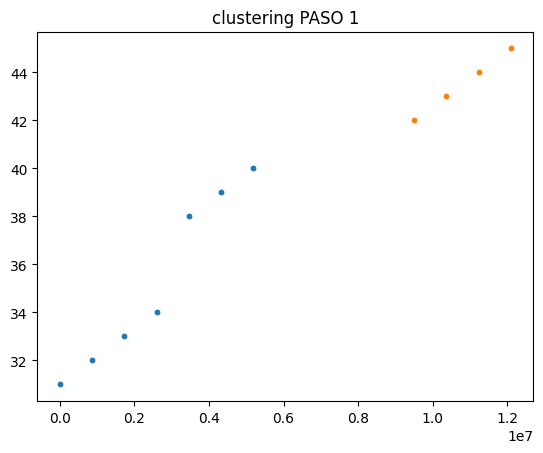

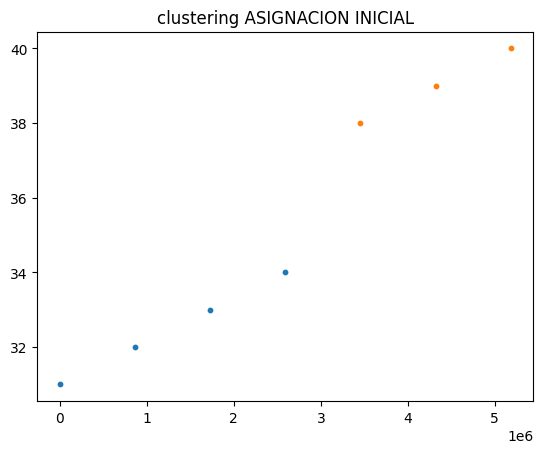

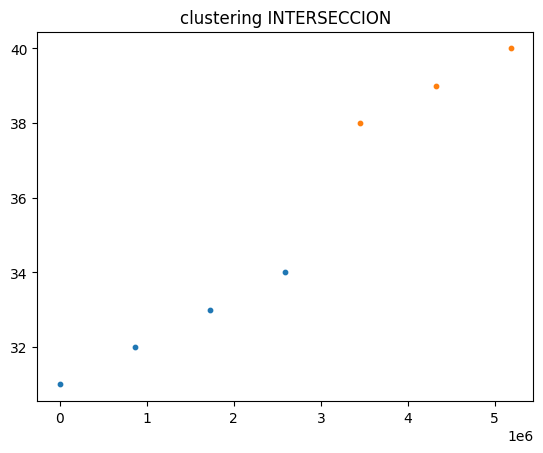

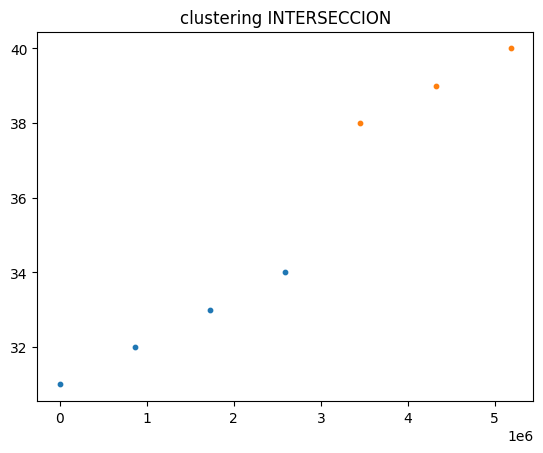

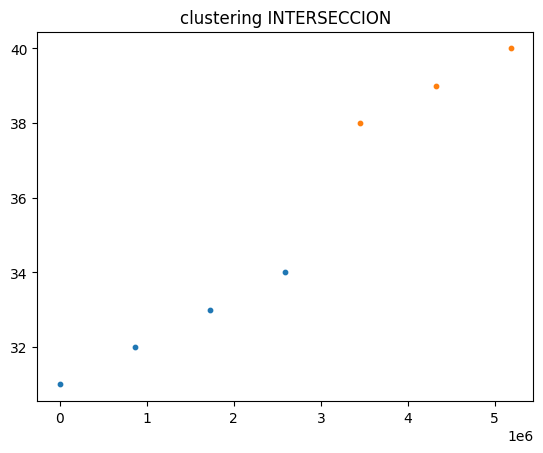

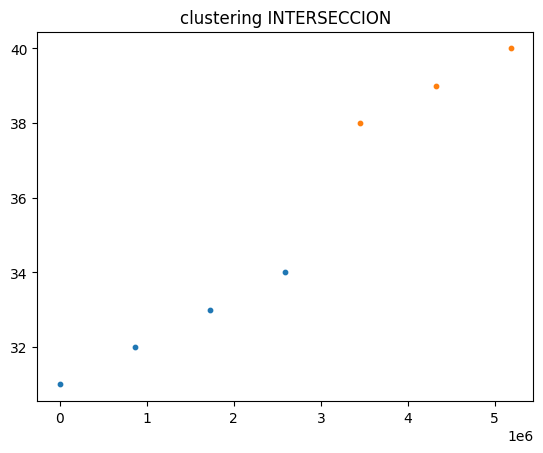

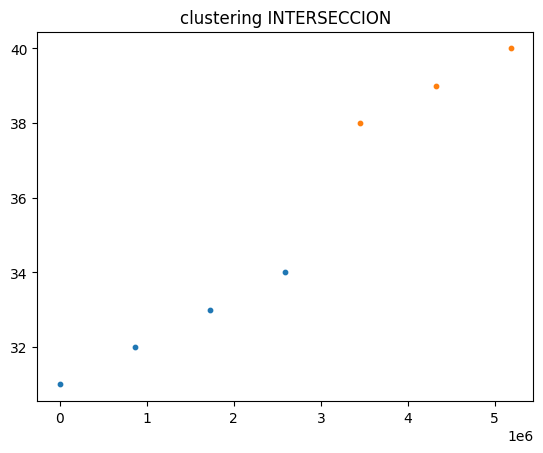

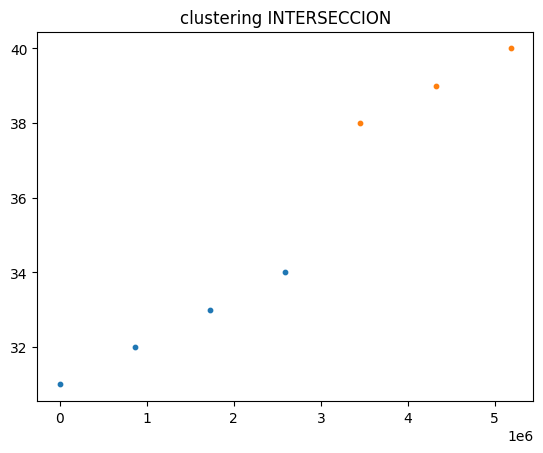

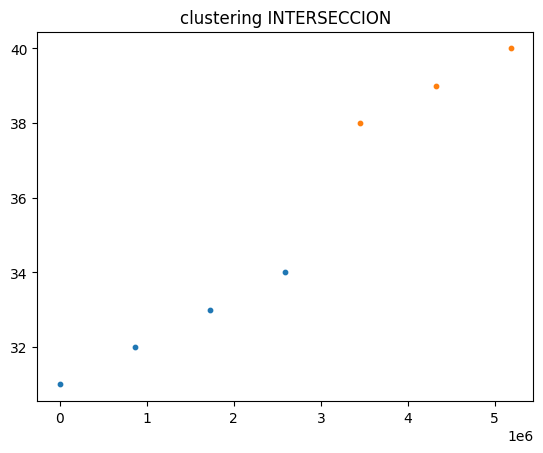

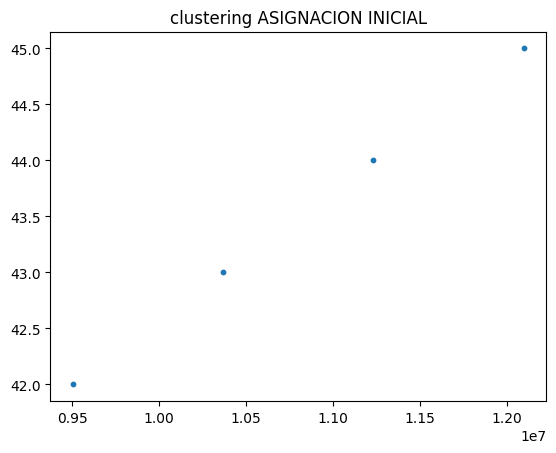

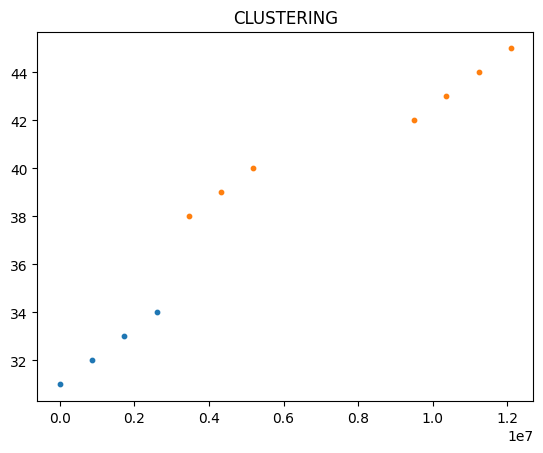

,dia,fecha_unix,diametro,cluster
0,0.0,0,31.0,0
1,1.0,864000,32.0,0
2,2.0,1728000,33.0,0
3,3.0,2592000,34.0,0
4,4.0,3456000,38.0,1
5,5.0,4320000,39.0,1
6,6.0,5184000,40.0,1
7,11.0,9504000,42.0,1
8,12.0,10368000,43.0,1
9,13.0,11232000,44.0,1


In [6]:
df_prueba = pd.DataFrame()

df_prueba['dia'] = [0.,1.,2.,3.,4.,5.,6.,11.,12.,13.,14.]
df_prueba['fecha_unix'] = [0,864000,1728000,2592000,3456000,4320000,5184000,9504000,10368000,11232000,12096000]
df_prueba['diametro'] = [31.0,32.0,33.0,34.0,38.0,39.0,40.0,42.0,43.,44.,45.0]
fit(df_prueba)